In [ ]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------
# lectura de datos:
# ---------------------------------------------

study_name = "lightgbm10"
df = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/sell-in.txt.gz", sep="\t")
productos = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/tb_productos.txt", sep="\t")
productos = productos.drop_duplicates(subset=["product_id"],keep="first")  # Eliminar duplicados por si acaso
stocks = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/tb_stocks.txt", sep="\t")
productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")

df = df[df["product_id"].isin(productos_ok["product_id"])]
# ---------------------------------------------
# Agrupacion por periodo y producto:
# ---------------------------------------------
df = df.groupby(by=["periodo","product_id"]).agg({
    "tn":"sum",
    "plan_precios_cuidados":"first",
    "customer_id":"nunique",
    }).reset_index()

# ---------------------------------------------
# Completar combinaciones periodo_producto:
# ---------------------------------------------
productos_list = df['product_id'].unique()
periodos = df['periodo'].unique()
idx = pd.MultiIndex.from_product([productos_list, periodos], names=['product_id', 'periodo'])
completo = idx.to_frame(index=False)
# 4 filtrar combinaciones periodo_producto
completo = completo.merge(df, on=['periodo', 'product_id'], how='left')
nacimiento_producto = df.groupby('product_id')['periodo'].min().rename('nacimiento_producto')

completo = completo.merge(nacimiento_producto, on='product_id', how='left')
completo = completo[completo['periodo'] >= completo['nacimiento_producto']]
df = pd.merge(completo, productos, how="left", on="product_id")
df = df.merge(stocks, how="left", on=["product_id", "periodo"])

# ---------------------------------------------
# Feature Engineering:
# ---------------------------------------------

# fechas
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")
df["mes"] = df["periodo"].dt.month
df["year"] = df["periodo"].dt.year
df["quarter"] = df["periodo"].dt.quarter

# totales por cat1 por periodo
df["cat1_total"] = df.groupby(["periodo", "cat1"])["tn"].transform("sum")
df["cat1_customers"] = df.groupby(["periodo", "cat1"])["customer_id"].transform("nunique")
# totales por cat2 por periodo
df["cat2_total"] = df.groupby(["periodo", "cat2"])["tn"].transform("sum")
df["cat2_customers"] = df.groupby(["periodo", "cat2"])["customer_id"].transform("nunique")
# totales por cat3 por periodo
df["cat3_total"] = df.groupby(["periodo", "cat3"])["tn"].transform("sum")
df["cat3_customers"] = df.groupby(["periodo", "cat3"])["customer_id"].transform("nunique")


# Lags
meses = ["tn"]
for i in range(1, 13):
    df[f"tn_t{i}"] = df.groupby("product_id")["tn"].shift(i)
    df[f"delta_t{i}"] = df[f"tn"] / df[f"tn_t{i}"]
    meses.append(f"tn_t{i}")
    df[f"cat1_t{i}"] = df.groupby("product_id")["cat1_total"].shift(i)
    df[f"cat2_t{i}"] = df.groupby("product_id")["cat2_total"].shift(i)
    df[f"cat3_t{i}"] = df.groupby("product_id")["cat3_total"].shift(i)
    df[f"customer_id_t{i}"] = df.groupby("product_id")["customer_id"].shift(i)
  
# agregaciones
df["promedio_t12"] = df[meses].mean(axis=1)
df["promedio_t6"] = df[meses[:6]].mean(axis=1)
df["promedio_t3"] = df[meses[:3]].mean(axis=1)

df["mediana_t12"] = df[meses].median(axis=1)
df["mediana_t6"] = df[meses[:6]].median(axis=1)
df["mediana_t3"] = df[meses[:3]].median(axis=1)

df["maximo_t12"] = df[meses].max(axis=1)
df["maximo_t6"] = df[meses[:6]].max(axis=1)
df["maximo_t3"] = df[meses[:3]].max(axis=1)

df["minimo_t12"] = df[meses].min(axis=1)
df["minimo_t6"] = df[meses[:6]].min(axis=1)
df["minimo_t3"] = df[meses[:3]].min(axis=1)

# Función para calcular la pendiente de una serie temporal
def calcular_pendiente(serie):
    datos = serie.dropna().values
    if len(datos) < 2:  # Mínimo 2 puntos para una regresión
        return np.nan
    x = np.arange(len(datos))  # [0, 1, 2, ..., n-1] (representa el tiempo)
    slope, _, _, _, _ = linregress(x, datos)
    return slope

# Aplicamos la función por grupo (producto) y reindexamos para alinear con df
df["pendiente_reg_12"] = (
    df.groupby("product_id")[meses]
    .apply(lambda grupo: grupo.apply(calcular_pendiente, axis=1))
    .reset_index(level=0, drop=True)  # Eliminamos el nivel de grupo para alinear índices
)
# medias móviles
df['media_movil_3m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(3).mean())
df['media_movil_6m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(6).mean())
df['media_movil_12m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(12).mean())
df['diff_media_3_6'] = df['media_movil_3m'] - df['media_movil_6m']
df['diff_media_6_12'] = df['media_movil_6m'] - df['media_movil_12m']
df['diff_media_3_12'] = df['media_movil_3m'] - df['media_movil_12m']
df["diff_tn_mm3"] = df["tn"] - df['media_movil_3m']
df["diff_tn_mm6"] = df["tn"] - df['media_movil_6m']
df["diff_tn_mm12"] = df["tn"] - df['media_movil_12m']

#Moda o patrón de cantidad
def rolling_mode(x):
    return x.shift(1).rolling(6, min_periods=1).apply(lambda x: mode(x, keepdims=True)[0][0], raw=False)
df['modo_6m'] = df.groupby(['product_id'])['tn'].transform(rolling_mode)
df['modo_diff'] = df['tn'] - df['modo_6m']


# variables categóricas
cat_cols = ['cat1', 'cat2', 'cat3', 'brand', 'plan_precios_cuidados']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
df = df.drop(columns=["descripcion"])

# ---------------------------------------------
# Target:
# ---------------------------------------------
df["target"] = df.groupby("product_id")["tn"].shift(-2)


del completo, productos, stocks, nacimiento_producto
gc.collect()
df

,product_id,periodo,tn,plan_precios_cuidados,customer_id,nacimiento_producto,cat1,cat2,cat3,brand,...,media_movil_12m,diff_media_3_6,diff_media_6_12,diff_media_3_12,diff_tn_mm3,diff_tn_mm6,diff_tn_mm12,target,modo_6m,modo_diff
0,20001,2017-01-01,934.77222,0,186.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.35771,NaN,NaN
1,20001,2017-02-01,798.01620,0,185.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1069.96130,934.77222,-136.75602
2,20001,2017-03-01,1303.35771,0,188.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,291.309000,NaN,NaN,1502.20132,798.01620,505.34151
3,20001,2017-04-01,1069.96130,0,104.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,12.849563,NaN,NaN,1520.06539,798.01620,271.94510
4,20001,2017-05-01,1502.20132,0,238.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,210.361210,NaN,NaN,1030.67391,798.01620,704.18512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22370,21087,2019-12-01,1.02205,0,51.0,201909,2,3,3,23,...,NaN,NaN,NaN,NaN,-0.087857,NaN,NaN,NaN,0.29997,0.72208
22371,21214,2019-09-01,0.34250,0,2.0,201909,2,3,65,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.84012,NaN,NaN
22372,21214,2019-10-01,0.21735,0,38.0,201909,2,3,65,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24428,0.34250,-0.12515
22373,21214,2019-11-01,0.84012,0,43.0,201909,2,3,65,23,...,NaN,NaN,NaN,NaN,0.373463,NaN,NaN,NaN,0.21735,0.62277


In [ ]:
# ---------------------------------------------
# Dataframe para Kgl
# ---------------------------------------------
df_kgl = df[df["periodo"] == "2019-12-01"]
df_kgl["periodo"] = df_kgl["periodo"].astype(int)
df = df[~df["periodo"].isin(["2019-11-01", "2019-12-01"])]


In [ ]:
# ---------------------------------------------
# Train/Validation Split:
# ---------------------------------------------
X = df.drop(columns=["target"])
y = df["target"]
X_train = X[X["periodo"] < '2019-10-01']
X_train["periodo"] = X_train["periodo"].astype(int)
y_train = y[X["periodo"] < '2019-10-01']

X_val = X[X["periodo"] == '2019-10-01']
X_val["periodo"] = X_val["periodo"].astype(int)
y_val = y[X["periodo"] == '2019-10-01']



In [ ]:
# ---------------------------------------------
# optimización con optuna realizada para este modelo:
# ---------------------------------------------

# import lightgbm as lgb
# import optuna
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import os
# === 1. Definición de custom MAPE ===
# def custom_mape_loss(y_true, y_pred):
#     numerator = np.sum(np.abs(y_true - y_pred))
#     denominator = np.sum(np.abs(y_true))
#     epsilon = np.finfo(float).eps  # Valor muy pequeño para evitar división por cero
#     return numerator / (denominator + epsilon)

# # === 2. Definición del objetivo para Optuna ===
# def objective(trial):
#     params = {
#         "sample_weight": X_train["tn"].to_list(),
#         "objective": "regression",
#         "metric": ["rmse", "mape"],
#         "boosting_type": "gbdt",
#         "verbosity": -1,
#         "n_jobs": -1,
#         "seed": 42,
#         "num_leaves": trial.suggest_int("num_leaves", 20, 200),
#         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 0.95),
#         "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 5.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 5.0, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 18),
#         "max_bin": trial.suggest_int("max_bin", 10, 4000),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
#         "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
#         "path_smooth": trial.suggest_float("path_smooth", 0, 1),  # Nuevo parámetro útil
#     }

#     model = lgb.train(
#         params,
#         lgb.Dataset(X_train, label=y_train),
#         valid_sets=[lgb.Dataset(X_val, label=y_val)],
#         num_boost_round=1000,
#         callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
#     )

#     preds = model.predict(X_val)
    
    
    
#     mape = custom_mape_loss(y_val, preds)
#     # rmse = mean_squared_error(y_val, preds)
#     # rmse = np.sqrt(rmse)
    
#     #rmse = mean_squared_error(y_val, preds, squared=False)
#     return mape

# # === 3. Configurar almacenamiento SQLite para Optuna ===
# os.makedirs("optuna_storage", exist_ok=True)
# DB_PATH = "optuna_storage/optuna.db"
# STUDY_NAME = study_name
# storage_url = f"sqlite:///{DB_PATH}"

# # === 4. Crear o cargar estudio ===
# study = optuna.create_study(
#     study_name=STUDY_NAME,
#     storage=storage_url,
#     direction="minimize",
#     load_if_exists=True
# )

# # === 5. Ejecutar optimización ===
# study.optimize(objective, n_trials=100)

In [ ]:
# ---------------------------------------------
# Modelo final:
# ---------------------------------------------
import lightgbm as lgb
# best_params optimizados con Optuna
best_params = {
    'num_leaves': 164,
    'learning_rate': 0.09719733130839447,
    'feature_fraction': 0.8776009045339863,
    'bagging_fraction': 0.897009475207526,
    'bagging_freq': 1,
    'min_child_samples': 39,
    'lambda_l1': 0.001006383403170569,
    'lambda_l2': 3.1230120464005275,
    'max_depth': 15,
    'max_bin': 998,
    'min_data_in_leaf': 128,
    'extra_trees': False,
    'path_smooth': 0.4671728684673886,
    'objective': 'regression',
    'metric': ['rmse', 'mape'],
    'verbosity': -1,
    'n_jobs': -1,
    'seed': 42}

model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# ---------------------------------------------
# Predict:
# ---------------------------------------------
# Asegurar las mismas columnas
X_kgl = df_kgl[X_train.columns]  # Misma estructura

# === Hacer predicción sobre nuevos datos ===
preds_kgl = model.predict(X_kgl)


In [ ]:
# ---------------------------------------------
# Resultados:
# ---------------------------------------------
result = pd.DataFrame({"product_id": X_kgl["product_id"],  "tn": preds_kgl})
result = result[result["product_id"].isin(productos_ok["product_id"])]
result.loc[result["tn"] < 0, "tn"] = 0  # Asegurar que no haya valores negativos
result

,product_id,tn
35,20001,1384.421698
71,20002,1105.965210
107,20003,892.024268
143,20004,593.078658
179,20005,587.307835
...,...,...
22358,20962,2.960315
22362,20975,2.821064
22366,20995,2.821064
22370,21087,2.489595


In [ ]:
# ---------------------------------------------
# CSV KGL:
# ---------------------------------------------
result.to_csv(f"lgb_118_cols.csv",sep=',', index=False)

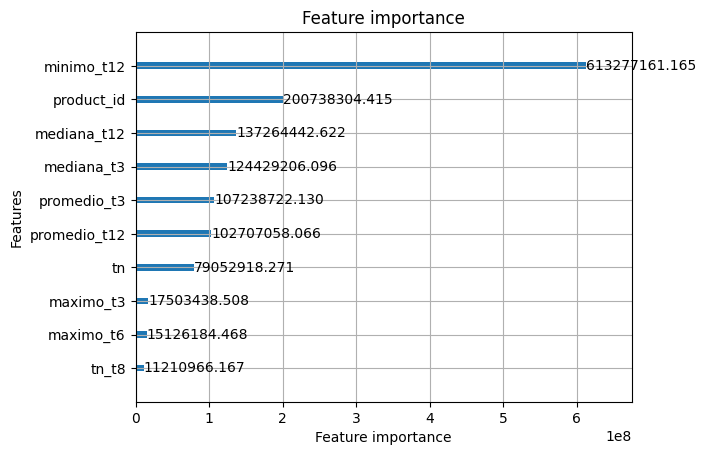

In [ ]:
# ---------------------------------------------
# Matriz de importancia:
# ---------------------------------------------
import matplotlib.pyplot as plt
from lightgbm import plot_importance  # Importación específica
# Visualizar importancia de características
plot_importance(model, importance_type='gain', max_num_features=10)  # Usar la función importada
plt.show()